# Autoencoders

<!--<badge>--><a href="https://colab.research.google.com/github/TheAIDojo/Machine_Learning_Bootcamp/blob/main/Week 08 – Computer Vision Applications/1- Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->




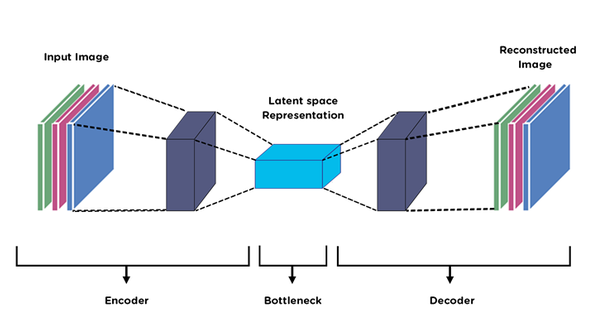

**Autoencoders** : are artificial neural networks capable of learning dense representations of the input data, called latent representations or codings, without any supervision (i.e., the training set is unlabeled).

These codings typically have a much lower dimensionality than the input data, making autoencoders useful for dimensionality reduction, especially for visualization purposes.

Autoencoders also act as feature detectors, and they can be used for unsupervised pretraining of deep neural networks.

Lastly, some autoencoders are generative models: they
are capable of randomly generating new data that looks very similar to the training data.

For example, you could train an autoencoder on pictures of faces, and it would
then be able to generate new faces. However, the generated images are usually fuzzy and not entirely realistic.
## How Autoencoders are Working
**Autoencoder**  In the case of image data, the autoencoder will first encode the image into a lower-dimensional representation, then decodes that representation back to the image. Encoder-Decoder automatically consists of the following two structures:

* **The encoder**- This network downsamples the data into lower dimensions.
* **The decoder**- This network reconstructs the original data from the lower dimension representation.
The lower dimension (i.e, output of encoder network) representation is usually known as latent space representation.


Before we get into the technical details of Autoencoder, let us look at some interesting applications it is used in:


*   Remove noise from an image (denoising).


Clearing noise and clarifying the details in an image

*   Fill in the missing pieces in an image (Image Inpainting).


Demo of filling in missing pieces of an image

* Dimensionality reduction, clustering, and in recommender systems.

* A class of Autoencoder known as Variational Autoencoder can even learn to generate data.

* Autoencoders are used as a Feature Extractor for downstream tasks such as  classification, and detection.

* Autoencoders are also widely leveraged in Semantic Segmentation.



#Denoising Autoencoders



#Image denoising
**Image Denoising** is the process of removing noise from the Images
The noise present in the images may be caused by various intrinsic or extrinsic conditions which are practically hard to deal with.

 The problem of Image Denoising is a very fundamental challenge in the domain of Image processing and Computer vision. Therefore, it plays an important role in a wide variety of domains where getting the original image is really important for robust performance.


In other words we force the autoencoder to learn useful features be  adding a noise to its inputs, training it to recover the original, noise-free inputs.

An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

#Import the python libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# download the required dataset from kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

 99% 659M/663M [00:10<00:00, 88.7MB/s]
100% 663M/663M [00:10<00:00, 68.9MB/s]


In [ ]:
!unzip /content/tuberculosis-tb-chest-xray-dataset.zip

Archive:  /content/tuberculosis-tb-chest-xray-dataset.zip
  inflating: TB_Chest_Radiography_Database/Normal.metadata.xlsx  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-10.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-100.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1000.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1001.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1002.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1003.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1004.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1005.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1006.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1007.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1008.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1009.png 

In [ ]:
# import python libraries for the project
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
from sklearn import model_selection
from sklearn.metrics import accuracy_score, precision_score, recall_score



from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split



from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm


tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


# Load Data

In [ ]:
@tf.function
def add_noise_image(images):
    noise_facrue=0.2
    noise=images+noise_facrue*tf.random.normal(shape=images.shape)
    noise=tf.clip_by_value(noise,0.0,1.0)



    return noise

In [ ]:
#Load first n number of images (to train on a subset of all images)
#For demo purposes, let us use 854 images
n=3500
path="/content/TB_Chest_Radiography_Database/Normal/"
lr_list = os.listdir(path)[:n]

normal_images = []
noise_images = []
for img in lr_list:
    img_lr = cv2.imread(path + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2GRAY)
    img_lr = cv2.resize(img_lr, (256,256))
    img_lr=img_lr.astype('float32')/255.
    normal_images.append(img_lr)
    img_lr = add_noise_image(img_lr)
    noise_images.append(img_lr)


noise_images = np.array(noise_images)
normal_images = np.array(normal_images)

noise_images = noise_images[..., tf.newaxis]
normal_images = normal_images[..., tf.newaxis]  # add another dimention



In [ ]:
train_noise_image, validation_noise_image, train_normal_image, validation_normal_image = train_test_split(noise_images, normal_images,
                                                      test_size=0.1, random_state=42)

del(normal_images)
del(noise_images)

In [ ]:
train_noise_image.dtype , np.max(train_noise_image)

(dtype('float32'), 1.0)

In [ ]:
validation_noise_image.shape , train_noise_image.shape

((350, 256, 256, 1), (3150, 256, 256, 1))

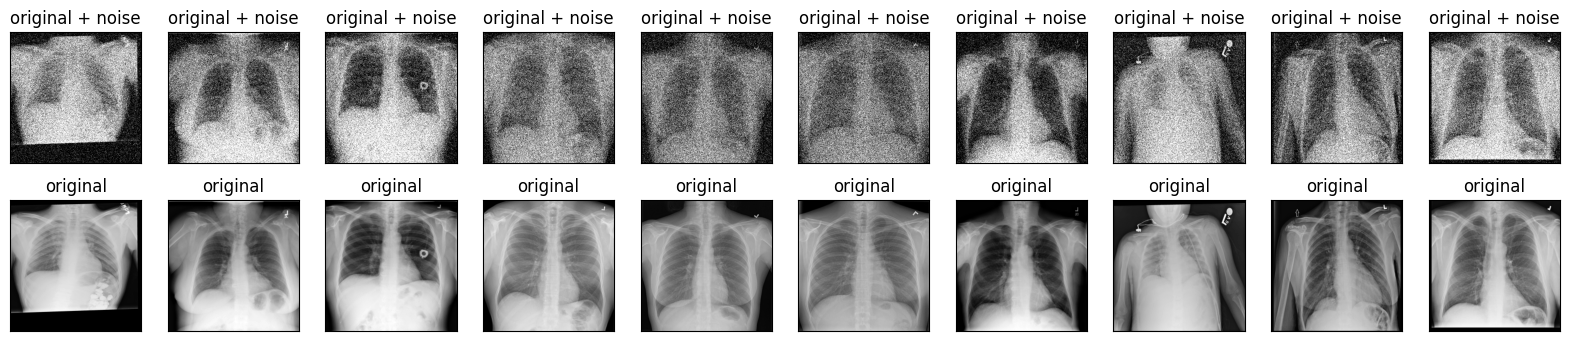

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(train_noise_image[i]))  # plot the noisy images
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    bx = plt.subplot(2, n, n + i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(train_normal_image[i]))  # plot  images without noise
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)


plt.show()

In [ ]:
plt.imsave("noise1.png",validation_noise_image[0].reshape(256,256))
plt.imsave("noise2.png",validation_noise_image[1].reshape(256,256))
plt.imsave("noise3.png",validation_noise_image[2].reshape(256,256))

# Create the Autoencoders Model

## Encoder
Here, we define the encoder network, which takes an input of size [None, 28, 28, 1]. There are five Conv blocks, each consisting of a Conv2D, BatchNorm and LeakyReLU activation function. at the second Conv and fourth Conv the image is down sampled by a factor of two.

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()

        # block 1
        # conv2D that have 16 filters with kernel_size=(3,3) with strides=(1,1)
        self.Conv_1 = tf.keras.layers.Conv2D(
            filters=16,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            use_bias=False,
        )
        self.BN_1 = tf.keras.layers.BatchNormalization()
        # block 2
        # conv2D that have 32 filters with kernel_size=(3,3) with strides=(2,2)
        # block 2 used to down sampling image size from 28,28 to 14,14
        self.Conv_2 = tf.keras.layers.Conv2D(
            filters=32,
            kernel_size=(3, 3),
            strides=(2, 2),
            padding="same",
            use_bias=False,
        )
        self.BN_2 = tf.keras.layers.BatchNormalization()
        # block 3
        # conv2D that have 64 filters with kernel_size=(3,3) with strides=(1,1)
        self.Conv_3 = tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            use_bias=False,
        )
        self.BN_3 = tf.keras.layers.BatchNormalization()
        # block 4
        # conv2D that have 128 filters with kernel_size=(3,3) with strides=(2,2)
        # block 4 used to down sampling image size from 14,14 to 7,7
        self.Conv_4 = tf.keras.layers.Conv2D(
            filters=128,
            kernel_size=(3, 3),
            strides=(2, 2),
            padding="same",
            use_bias=False,
        )
        self.BN_4 = tf.keras.layers.BatchNormalization()
        # block 5
        # conv2D that have 256 filters with kernel_size=(3,3) with strides=(1,1)
        self.Conv_5 = tf.keras.layers.Conv2D(
            filters=256,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            use_bias=False,
        )
        self.BN_5 = tf.keras.layers.BatchNormalization()

    def call(self, x):
        # block 1
        x = self.Conv_1(x)
        x = self.BN_1(x)
        x = tf.nn.leaky_relu(x)
        # block 2
        x = self.Conv_2(x)
        x = self.BN_2(x)
        x = tf.nn.leaky_relu(x)
        # block 3
        x = self.Conv_3(x)
        x = self.BN_3(x)
        x = tf.nn.leaky_relu(x)
        # block 4
        x = self.Conv_4(x)
        x = self.BN_4(x)
        x = tf.nn.leaky_relu(x)
        # block 5
        x = self.Conv_5(x)
        x = self.BN_5(x)
        x = tf.nn.leaky_relu(x)

        return x

    def build_model(self, dim):
        x = tf.keras.layers.Input(shape=dim)
        return tf.keras.Model(inputs=[x], outputs=[self.call(x)])


encoder = Encoder()
encoder.build_model((256,256, 1)).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      144       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 16)     64        
 ormalization)                                                   
                                                                 
 tf.nn.leaky_relu (TFOpLambd  (None, 256, 256, 16)     0         
 a)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4608      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128   

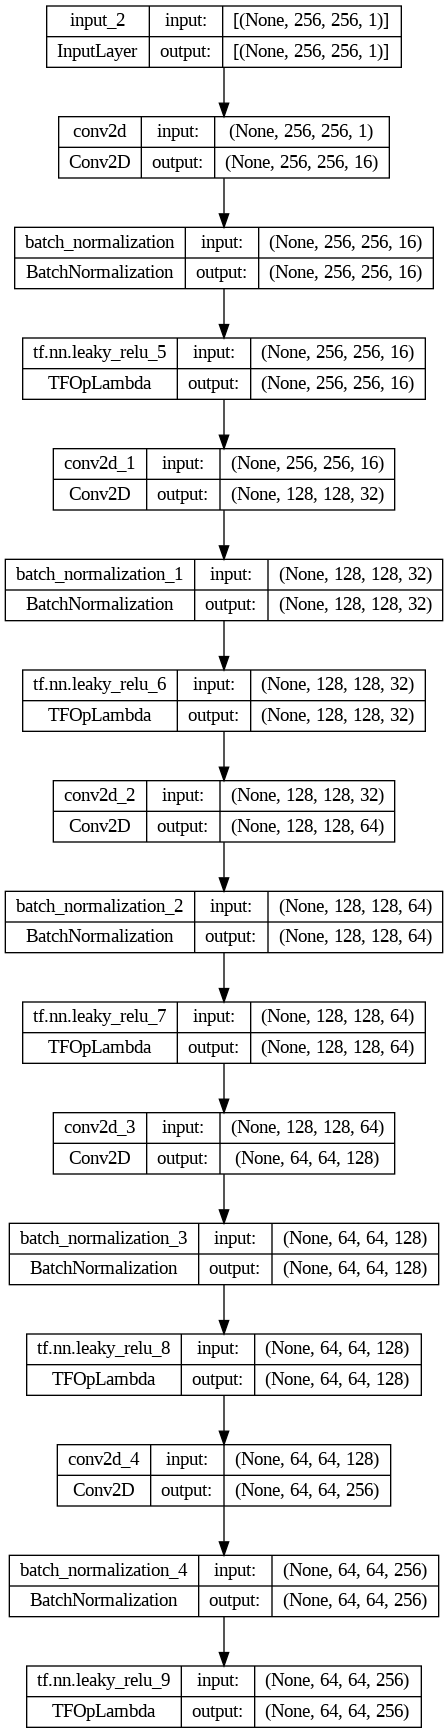

In [ ]:
tf.keras.utils.plot_model(encoder.build_model((256, 256, 1)), show_shapes=True)

## Decoder
At the Decoder we are using special Convolution layer called Conv2DTranspose .

**[Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)** is a convolution operation whose kernel is learnt (just like normal conv2d operation) while training your model. Using Conv2DTranspose will also upsample  its input by using nearest neighbour or bilinear upsampling, but the key difference from the Conv2D is the model should learn what is the best upsampling for the job.  


The decoder network takes an input of size [None,7,7 256].

The initial block has a Conv2DTranspose layer having 256 filters.

Recall that this was the size of the output in the encoder function .

There are a total of six Conv blocks. The Conv block [1, 5] consists of a Conv2DTranspose, BatchNorm and LeakyReLU activation function.

The Conv block 6 has a Conv2DTranspose with sigmoid activation function, which flattens  the output to be in the range [0, 1].

 In each block, the image is up sampled by a factor of two at block 2 and 4 .

In [66]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        # block 1
        # Conv2DTranspose that have 256 filters with kernel_size=(3,3) with strides=(1,1) that matches the output of the encoder
        self.Conv_1 = tf.keras.layers.Conv2DTranspose(
            filters=256,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            use_bias=False,
        )
        self.BN_1 = tf.keras.layers.BatchNormalization()
        # block 2
        # Conv2DTranspose that have 128 filters with kernel_size=(3,3) with strides=(2,2)
        # we're using stride ==(2,2) to upsample the size of the input
        self.Conv_2 = tf.keras.layers.Conv2DTranspose(
            filters=128,
            kernel_size=(3, 3),
            strides=(2, 2),
            padding="same",
            use_bias=False,
        )
        self.BN_2 = tf.keras.layers.BatchNormalization()
        # block 3
        # Conv2DTranspose that have 64 filters with kernel_size=(3,3) with strides=(1,1)
        self.Conv_3 = tf.keras.layers.Conv2DTranspose(
            filters=64,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            use_bias=False,
        )
        self.BN_3 = tf.keras.layers.BatchNormalization()
        # block 4
        # Conv2DTranspose that have 32 filters with kernel_size=(3,3) with strides=(2,2)
        # we're using stride ==(2,2) to upsample the size of the input
        self.Conv_4 = tf.keras.layers.Conv2DTranspose(
            filters=32,
            kernel_size=(3, 3),
            strides=(2, 2),
            padding="same",
            use_bias=False,
        )
        self.BN_4 = tf.keras.layers.BatchNormalization()
        # block 5
        # Conv2DTranspose that have 128 filters with kernel_size=(3,3) with strides=(1,1)
        self.Conv_5 = tf.keras.layers.Conv2DTranspose(
            filters=16,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding="same",
            use_bias=False,
        )
        self.BN_5 = tf.keras.layers.BatchNormalization()
        # block 6
        # in this block we're using  Conv2DTranspose with  kernel size (1,1) so we can reduse the number of the channels to the same number
        # of channels in the input image
        self.Out = tf.keras.layers.Conv2DTranspose(
            filters=1, kernel_size=(1, 1), strides=(1, 1)
        )

        # Note : you can notice that we are build the same architecture of encoder but from output to input

    def call(self, x):
        # block 1
        x = self.Conv_1(x)
        x = self.BN_1(x)
        x = tf.nn.leaky_relu(x)
        # block 2

        x = self.Conv_2(x)
        x = self.BN_2(x)
        x = tf.nn.leaky_relu(x)
        # block 3

        x = self.Conv_3(x)
        x = self.BN_3(x)
        x = tf.nn.leaky_relu(x)
        # block 4

        x = self.Conv_4(x)
        x = self.BN_4(x)
        x = tf.nn.leaky_relu(x)
        # block 5
        x = self.Conv_5(x)
        x = self.BN_5(x)
        x = tf.nn.leaky_relu(x)
        # block 6
        # notice we're using sigmoid to make sure the output value of the last Conv2DTranspose will be between 0,1

        output = self.Out(x)
        output = tf.nn.sigmoid(output)

        return output

    def build_model(self, dim):
        x = tf.keras.layers.Input(shape=dim)
        return tf.keras.Model(inputs=[x], outputs=[self.call(x)])


dncoder = Decoder()
dncoder.build_model((64, 64, 256)).summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 256)]     0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 64, 64, 256)      589824    
 Transpose)                                                      
                                                                 
 batch_normalization_20 (Bat  (None, 64, 64, 256)      1024      
 chNormalization)                                                
                                                                 
 tf.nn.leaky_relu_20 (TFOpLa  (None, 64, 64, 256)      0         
 mbda)                                                           
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 128, 128, 128)    294912    
 Transpose)                                                

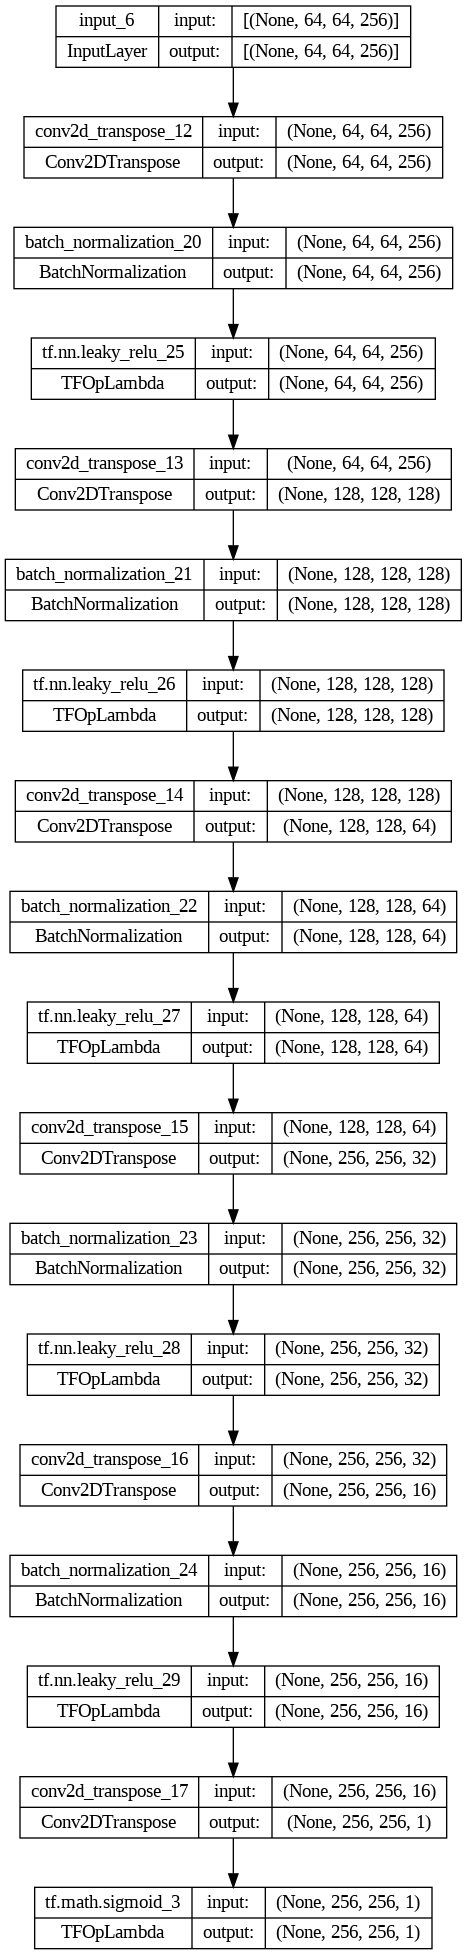

In [67]:
tf.keras.utils.plot_model(dncoder.build_model((64, 64, 256)), show_shapes=True)

##Autoencoder Model


In [68]:
class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # initialize the encoder
        self.encoder = Encoder()
        # initialize the decoder
        self.decoder = Decoder()

    def call(self, x):
        # input the noisy image to the encoder
        x = self.encoder(x)
        # input the ouput of the encoder to the decoder
        x = self.decoder(x)

        # return the ouput of the decoder
        # the ouput of the decoder will be denoising image

        return x


autoencoder = Autoencoder()
autoencoder.build(input_shape=(None, 256, 256, 1))

In [69]:
autoencoder.summary()

Model: "autoencoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_2 (Encoder)         multiple                  393808    
                                                                 
 decoder_3 (Decoder)         multiple                  983505    
                                                                 
Total params: 1,377,313
Trainable params: 1,375,329
Non-trainable params: 1,984
_________________________________________________________________


##train the model

In [70]:
autoencoder.compile(optimizer="adam", loss=tf.losses.MeanSquaredError())
                    # save the best model based on the validation loss


In [ ]:
history=autoencoder.fit(train_noise_image, train_normal_image, epochs=20, batch_size=50,
                        shuffle=True, validation_data=(validation_noise_image, validation_normal_image))

Epoch 1/20
63/63 [==============================] - 91s 1s/step - loss: 0.0075 - val_loss: 0.0335
Epoch 2/20
 8/63 [==>...........................] - ETA: 1:21 - loss: 0.0021

#model evaluation

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored

In [28]:
autoencoder.evaluate(validation_noise_image,verbose=2)

11/11 - 10s - loss: 0.0000e+00 - 10s/epoch - 887ms/step


0.0

 Accuracy is not defined for regression problems, the mean squared error you see its not a percentage, that is the actual value you get, it might be less than one

 --Accuracy doesn't make sense for a regression problem, hence the keras sample doesn't use that metric during autoencoder.compile.

In this case, keras calculates the accuracy as per this metric.

In [29]:
def binary_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=-1)
x_decoded = autoencoder.predict(validation_noise_image)
acc =1- np.mean(np.equal(validation_normal_image, np.round(x_decoded)))
print(acc)

11/11 [==============================] - 2s 208ms/step
0.9761514718191965


In [30]:
import keras.backend as K

def accuracy_with_tolerence(y_true, y_pred):
    threshold = 0
    differnece = tf.abs(tf.subtract(y_true, y_pred)) - threshold
    boolean_results = differnece
    return (1-K.mean(boolean_results))

acc = accuracy_with_tolerence(validation_normal_image , autoencoder.predict(validation_noise_image)).numpy()
print("accuracy=", acc)

11/11 [==============================] - 2s 207ms/step
accuracy= 0.9617942


# save and load model

In [31]:
autoencoder.save_weights('/content/drive/MyDrive/enhance_Xray_image.h5')

In [32]:
autoencoder.load_weights('/content/drive/MyDrive/enhance_Xray_image.h5')


##plot the prediction of the model

11/11 [==============================] - 2s 209ms/step


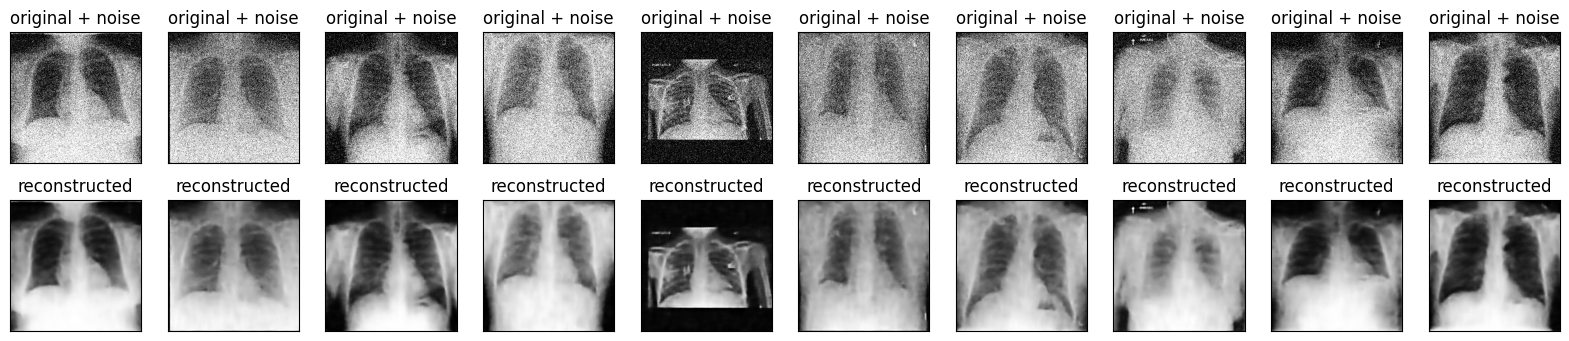

In [33]:
n = 10
plt.figure(figsize=(20, 4))
pred = autoencoder.predict(validation_noise_image)  # make prediction
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(validation_noise_image[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(pred[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

#Gradio

In [34]:
pip install gradio

In [35]:
import gradio as gr

255
(256, 256, 1)
1/1 [==============================] - 0s 49ms/step


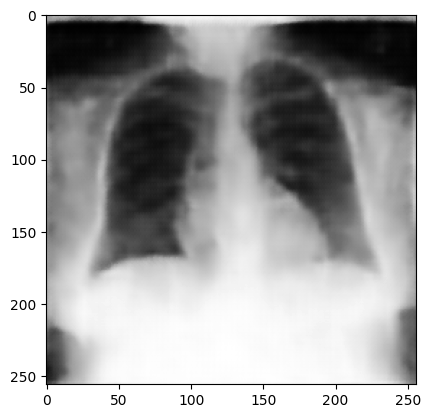

In [47]:
input=cv2.imread("/content/noise1.png")
img=cv2.cvtColor(input, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (SIZE, SIZE))
print(np.max(img))
img = img.astype('float32') / 255.0
img = img[..., tf.newaxis]
print(img.shape)
predicted = np.clip(autoencoder.predict(np.expand_dims(img,axis=0)),0.0,1.0).reshape(SIZE, SIZE,1)
plt.imshow(predicted, cmap='gray')

In [54]:
SIZE=256
def enhance_image(input):

    #resizing image
    img = cv2.resize(input, (SIZE, SIZE))
    print(np.max(img))
    img = img.astype('float32') / 255.0
    img = img[..., tf.newaxis]
    print(img.shape)
    predicted = np.clip(autoencoder.predict(np.expand_dims(img,axis=0)),0.0,1.0).reshape(SIZE, SIZE)

    return predicted

In [61]:
title = " XRay image Enahncment project "
description = """This project depand on deep learning approch
and can enhance xray grayscale image and fixed it
."""

In [65]:
gr.Interface(fn=enhance_image,
             inputs=[gr.Image( image_mode="L" , shape=(SIZE,SIZE), height=300, width=300,label="noise image")],
             outputs=[gr.Image( image_mode="L" , shape=(SIZE,SIZE), height=300, width=300,label="enhanced image")],
             examples=['./noise1.png','./noise2.png','./noise3.png'] ,
              title=title,
             description=description
             ).launch(share=True )

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://9baae49695364cf11f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
